# Improving Fraud Detection using AutoEncoders

What we did so far:

We have 28 Numerical features along with Time, Amount & Class. We got rid of Time as it was not impacting our decision making.
Our last model involved training the neural net on 29 features (28 numerical & 1 amount) by subsetting on non fraud data.
The non-fraud data model was then used to predict the test data (which had fraud transactions)
We then calculated MSE between the Actual values and predicted values of 29 features.

So from 29 features where we originally started, we created 1 feature which was then used with Class label and predicted the threshold for classifying.

Please note: as we had continous variables, we choose MSE as our error metric. Our predictions were continous not classes. We use MSE of all the features for predicting if a transaction is fraud.

What we will do here:

Recall, AutoEncoders do dimensionality reduction. Our Model was encoded starting with 29 features, reduced to 14, then to 7
we then decoded from 7 to 14, and then to 29.

We shall try using the 7 features of encoding model for predicting the classes.
As stated in previous note, as we are predicting continous variable, our error metric shall remain as MSE.

importing necessary libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(143)
LABELS = ["Normal", "Fraud"]
import warnings
warnings.filterwarnings('ignore')

Reading the data

In [2]:
data = pd.read_csv("data/creditcard.csv")

We already know from our last class that Time did not impact our predictions. We shall get rid of it.

In [3]:
data.drop(['Time'],axis =1 , inplace = True)

We do not have much preprocessing to be done, no null values as well. So lets split the data to train & test

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size = 0.2, random_state = 123)

print(f"The class distribution of train data is \n{(X_train['Class'].value_counts()/X_train.shape[0])*100}\n")
print(f"The class distribution of test data is \n{(X_test['Class'].value_counts()/X_test.shape[0])*100}")

The class distribution of train data is 
0    99.834537
1     0.165463
Name: Class, dtype: float64

The class distribution of test data is 
0    99.798111
1     0.201889
Name: Class, dtype: float64


In [5]:
print(X_train.head(3))
print("__________________________________")
print(X_test.head(3))

             V1        V2        V3        V4        V5        V6        V7  \
99168 -0.866221 -0.919624  2.020857 -1.525794 -1.035785  2.157966 -0.281997   
69460  0.967267 -0.179598  0.315800  1.354288 -0.273647  0.139429 -0.005874   
71073 -0.415673  1.080659  0.675844  0.789318  0.158613  0.430765  0.135873   

             V8        V9       V10  ...       V21       V22       V23  \
99168  0.608243 -0.595195 -0.192038  ...  0.511087  1.154578 -0.070794   
69460  0.174708  0.195502  0.040867  ... -0.015079 -0.078930 -0.131669   
71073  0.671417 -1.000854 -0.298512  ...  0.287891  0.782205  0.004812   

            V24       V25       V26       V27       V28  Amount  Class  
99168 -1.678518  0.511949  0.159084  0.044666  0.063497  229.00      0  
69460 -0.001284  0.565061 -0.334174  0.013635  0.017108   87.95      0  
71073 -0.271442 -0.301717 -0.287004 -0.015223 -0.034233   15.90      0  

[3 rows x 30 columns]
__________________________________
              V1        V2        V3

Get our labels y_train & y_test

In [6]:
y_train = X_train['Class']
X_train = X_train.drop(['Class'],axis = 1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'],axis = 1)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(227845, 29)
(227845,)
(56962, 29)
(56962,)


In [ ]:
#the amount variable is scaled 

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train['Amount'].values.reshape(-1, 1))

X_train['Amount'] = scaler.transform(X_train['Amount'].values.reshape(-1, 1))
X_test['Amount'] = scaler.transform(X_test['Amount'].values.reshape(-1, 1))

We have 29 features, let us build Encoding & Decoding Model

In [8]:
input_dim = X_train.shape[1]

encoding_dim = 14

# Note: since we look forward to use the encoder, we shall create an encoder to use the same for prediction

encoder = Model(inputs=input_layer, outputs=encoder) #This can be used to predict 7 variables out of 29 variables where we began with.

In [10]:
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from keras import regularizers

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu",kernel_regularizer=regularizers.l2(0.01))(input_layer) #activity_regularizer=l1(10e-5)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.1)(encoder)

#we will further reduce the dimension to 7
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(encoding_dim, activation="relu",kernel_regularizer=regularizers.l2(0.01))(encoder)
decoder = Dropout(0.1)(decoder)

decoder = Dense(input_dim, activation='linear')(decoder)

#we will extract the 7 feature model as below
encoder = Model(inputs=input_layer, outputs=encoder)

#in order to replicate 26 features we shall use below.
autoencoder = Model(inputs=input_layer, outputs=decoder)

Using TensorFlow backend.


In [11]:
autoencoder.compile(optimizer = 'adam', 
                    loss = 'mean_squared_error', 
                    metrics = ['mse'])

Unlike we did in our class(where we took only the non-fradulent data), we shall use the whole training data (both fraud and non- fraud) for training the model

In [12]:
hist = autoencoder.fit(X_train, 
                       X_train, 
                       epochs = 10, 
                       batch_size = 128, 
                       shuffle = True, 
                       validation_split = 0.3, 
                       verbose = 1)

Train on 159491 samples, validate on 68354 samples
Epoch 1/10
159491/159491 [==============================] - 5s 34us/sample - loss: 0.8701 - mse: 0.8031 - val_loss: 0.5870 - val_mse: 0.5642
Epoch 2/10
159491/159491 [==============================] - 5s 29us/sample - loss: 0.6582 - mse: 0.6395 - val_loss: 0.5337 - val_mse: 0.5169
Epoch 3/10
159491/159491 [==============================] - 4s 28us/sample - loss: 0.6194 - mse: 0.6034 - val_loss: 0.4957 - val_mse: 0.4810
Epoch 4/10
159491/159491 [==============================] - 5s 30us/sample - loss: 0.5952 - mse: 0.5811 - val_loss: 0.4706 - val_mse: 0.4572
Epoch 5/10
159491/159491 [==============================] - 4s 26us/sample - loss: 0.5800 - mse: 0.5669 - val_loss: 0.4607 - val_mse: 0.4479
Epoch 6/10
159491/159491 [==============================] - 4s 27us/sample - loss: 0.5693 - mse: 0.5572 - val_loss: 0.4548 - val_mse: 0.4425
Epoch 7/10
159491/159491 [==============================] - 5s 29us/sample - loss: 0.5596 - mse: 0.5480

Predicting the 7 reduced features by recalling encoder model

In [13]:
red_train = encoder.predict(X_train)
red_test = encoder.predict(X_test)

AutoEncoder is mostly about dimensionality reduction, be it an image or a number of variables, 
We now have 7 features instead of 29.

We also have Denoising AutoEncoder, which reduces the noise. We intutively can assume that these 7 features have lesser noise than the original 29 features.

In [14]:
red_train.shape, red_test.shape

((227845, 7), (56962, 7))

# We now have 7 features and Ground truth 'Class'

The reduced dimensions shall now be used for our model building and predicting if a transaction is Fraud or Non-Fraud.
Note: here we are predicting class, not the continous variable. So our error metric would be F1 score (precisely F1 score as there is imbalance in the target variable)

In [15]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc
dtc.fit(red_train, y_train)
y_pred1_train = dtc.predict(red_train)
y_pred1_test = dtc.predict(red_test)

<IPython.core.display.Javascript object>


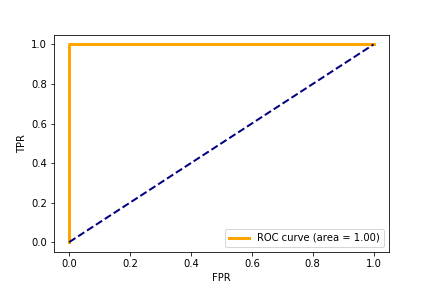

In [16]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_train, y_pred1_train)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
%matplotlib notebook
# plt.figure()
plt.plot(fpr,tpr,color='orange', lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")

In [18]:
from sklearn.metrics import f1_score,confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred1_test))
print(classification_report(y_test, y_pred1_test))

[[56820    27]
 [   30    85]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.76      0.74      0.75       115

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [19]:
from sklearn.linear_model import LogisticRegression
FN1 = LogisticRegression(random_state=200)
FN1.fit(X_train,y_train)
y_pred2_train = FN1.predict(X_train)
y_pred2_test = FN1.predict(X_test)

<IPython.core.display.Javascript object>


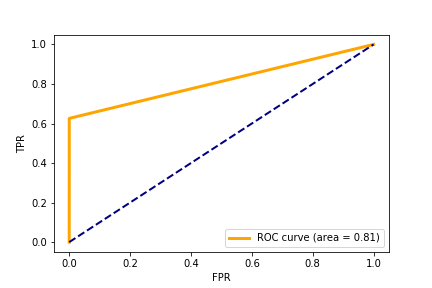

In [20]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_train, y_pred2_train)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
%matplotlib notebook
# plt.figure()
plt.plot(fpr,tpr,color='orange', lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")

In [22]:
print(confusion_matrix(y_test, y_pred2_test))
print(classification_report(y_test, y_pred2_test))

[[56833    14]
 [   45    70]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.83      0.61      0.70       115

    accuracy                           1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



Conclusion:

AutoEncoders could be used for reducing the features and also help to create better predictions by creating new features.
however, we cannot understand how these 7 features could explain the 29 features.

We can choose DecisionTreeClassifier as it had lesser wrongly predicted values for the said dataset.